# Pt2FE
- This is a demo for applying the Pt2FE method
- The demo are arranged in the following steps:
    - 1) Data Preparing
    - 2) Data Processing
    - 3) 3D Reconstruction
    - 4) Convert into ANSYS APDL workflow (FE Model)
- Although I called this demo as automatic, but somehow I have to admit that this demo was actually semi-auto to use. Since some parameters you need to decide by yourself.

- So, just put your orginal pointcloud data into the data/org_data file.
- Make sure that your file could be opened in the PointCloud software like CloudCompare or Geomagic Wrap...... in another word, make sure your file is .pcd(binary).
    - During the further steps, we may need several kinds of data format (.pcd(binary),.pcd(ascii),.csv and so on), so we prepared the format transformation function in the same-name file.
- The unit of your Pts data should consistent with the reality.

## Now, let's get started

## PART 1 : DATA PREPARING

#### let us use the open3d lib to have quick glance of your data.

In [4]:
import open3d as o3d
from data_preparing.visualize_pt import visualize_pcds

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [23]:
visualize_pcds(['data/org_data/jie6.pcd'])

[Open3D WARNING] Read PCD failed: unable to open file: data/org_data/jie6.pcd


In [6]:
file_name = "jie5"

- Compare the PointCloud data with your original one, make sure that they are formally same with each other

- Then, we can transfer your orginal .pcd file into different format

In [5]:
# transfer your original file
from format_transformation.ascii_to_binary import ascii_to_binary
from format_transformation.binary_to_ascii import binary_to_ascii
from format_transformation.pcd2txt import pcd_to_txt
from format_transformation.txt_2_csv import txt_to_csv
from format_transformation.asc_adjust import process_ascii_pcd, process_ascii_pcd_rgb

In [13]:
#ascii_to_binary(f"./data/org_data/{file_name}.pcd",f"./data/org_data/data_{file_name}_b.pcd")

In [11]:
binary_to_ascii(f"./data/org_data/{file_name}.pcd",f"./data/org_data/{file_name}_asc_temp.pcd")

Hello, world!
PointCloud_source has: 398154 data points.


In [12]:
#adjust the asc_data in order to make the format of the file are the same
process_ascii_pcd_rgb(f"./data/org_data/{file_name}_asc_temp.pcd",f"./data/org_data/{file_name}_asc.pcd")

In [13]:
ascii_to_binary(f"./data/org_data/{file_name}_asc.pcd",f"./data/org_data/{file_name}_b.pcd")

In [7]:
pcd_to_txt(f"./data/org_data/{file_name}_asc.pcd", f"./data/org_data/{file_name}_txt.txt")

In [8]:
txt_to_csv(f"./data/org_data/{file_name}_txt.txt", f"./data/org_data/{file_name}_csv.csv")

In [4]:
import pandas as pd

In [10]:
csv_file = pd.read_csv(f"./data/org_data/{file_name}_csv.csv")
csv_file.drop(0,inplace=True)
#csv_file.reset_index(drop=True, inplace=True)
csv_file.to_csv(f"./data/org_data/{file_name}_csv.csv", index=False)

c:\Users\ADMIN\.conda\envs\pointcloud\lib\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning: Columns (0,1,2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## PART 2 : DATA PROCESSING

- Now, we are going to the data processing step.

### 2.1 : Coordinate Adjustment

- If your data are offset with the reality, you may could apply this part
- In this section, we may also use plane fitting method, which we would discuss later in section 2.2

- 2.1.1 clustering the data in order to find the different planes in your data

In [8]:
#2.1.1 clustering the data in order to find the different planes in your data
import numpy as np

from data_processing.algorithm_clustering.points_to_surface3 import initialize_planes_with_kmeans, refine_planes

In [21]:
points_sample = np.loadtxt(f'./data/org_data/{file_name}_txt.txt',skiprows=1)
n_planes = 3

In [22]:
initial_planes = initialize_planes_with_kmeans(points_sample, n_planes)
refined_planes, refined_assignments = refine_planes(points_sample, initial_planes)

In [13]:
#visualization
from data_processing.algorithm_clustering.points_to_surface3 import plot_points_by_group

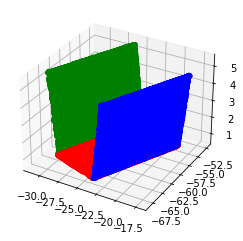

In [24]:
plot_points_by_group(points_sample, refined_assignments)

- To see whether if the result does make sense to the reality. (Each color represent to a plane) 
- The Relationship between color and plane number:
    - ['r', 'g', 'b','orange','purple','black']

In [25]:
#将结果存入.csv文件
import pandas as pd
ass_series = pd.Series(refined_assignments)
csv_file = f'./data/org_data/{file_name}_csv.csv'
df = pd.read_csv(csv_file)
df['cluster'] = ass_series
df.to_csv(f"./data/org_data/{file_name}_clu.csv", index=False)

- visualize the planes

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

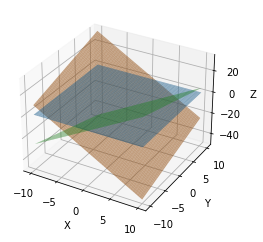

In [27]:
#visualize the planes that we fitted
planes_fig = refined_planes

# 创建数据点
x = np.linspace(-10, 10, 100) #绘图范围
y = np.linspace(-10, 10, 100)
x, y = np.meshgrid(x, y)

# 创建3D图形
fig = plt.figure()
plt3d = fig.add_subplot(111, projection='3d')

# 绘制多个平面
for plane in planes_fig:
    A, B, C, D = plane
    z = (-A * x - B * y - D) / C
    plt3d.plot_surface(x, y, z, alpha=0.5)

# 设置坐标轴标签
plt3d.set_xlabel('X')
plt3d.set_ylabel('Y')
plt3d.set_zlabel('Z')

# 显示图形
plt.show()

- 补充：
    - 因为有时候计算整体点云数据的主方向有误差，因此我们借助底面（cluster=1）的点进行主方向计算

In [53]:
import pandas as pd

In [54]:
adj_file = pd.read_csv(f'./data/org_data/{file_name}_clu.csv')
adj_file.head()

,x,y,z,cluster
0,-29.900181,-64.930611,1.32560,1
1,-29.892250,-64.918411,1.33184,1
2,-29.886480,-64.927277,1.28754,1
3,-29.882641,-64.934158,1.28416,1
4,-29.879770,-64.934959,1.26348,1


In [55]:
points_file = adj_file.loc[adj_file.cluster==1,:]
points_file.iloc[:,:3].to_csv(f'./data/org_data/{file_name}_dimian.csv',index=False) #底面数据

In [56]:
from format_transformation.csv2txt import csv_to_txt
from format_transformation.txt2pcd import txt_to_pcd

In [57]:
csv_to_txt(f'./data/org_data/{file_name}_dimian.csv',f'./data/org_data/{file_name}_dimian_txt.txt')

In [58]:
txt_to_pcd(f'./data/org_data/{file_name}_dimian_txt.txt',f'./data/org_data/{file_name}_dimian_pcd_asc.pcd')

In [59]:
ascii_to_binary(f'./data/org_data/{file_name}_dimian_pcd_asc.pcd',f'./data/org_data/{file_name}_dimian_pcd_b.pcd')

In [60]:
from data_processing.coordinate_transformation.show_pt_pca import visualize_point_cloud_with_pca_svd

In [61]:
visualize_point_cloud_with_pca_svd('./data/org_data/jie5_dimian_pcd_b.pcd') #see the main_direction

array([0.38257343, 0.92391709, 0.00384504])

- 2.1.2 Transform the Point Clouds data
    - literally contains 2 steps:
        - Find a vector (main_direction), which tis projection on surface X=0 will align to the (0,1,0) Y-axis
        - Find Which point are going to transform to (0,0,0)
        - ~~Let the bottom surface align with the standard surrface Z=0 (ignore this step in this demo)~~
    - However, if the model do not have a original bottom surface, using the intersection line to be the transformation object is also OK 

In [8]:
#from data_processing.transformation_PT import transform_points v1版本:仅平移
#from data_processing.coordinate_transformation.trans import align_and_translate_point_cloud #v2版本:主成分分析找旋转方向；平移
from data_processing.coordinate_transformation.trans_v3 import transform_point_cloud #v3:底面主成分对齐Y轴 + 平移

In [9]:
import os
# 假设 rotated_points 是你需要保存的numpy数组
# rotated_points = np.array(...) 

output_path = "./data/rotated_data"
output_file = f"{file_name}_rot_pcd_b.pcd"
full_path = os.path.join(output_path, output_file) #创建相应文件夹和.txt文件

# 确保目标路径存在
os.makedirs(output_path, exist_ok=True)

In [10]:
input_points_path = f"./data/org_data/{file_name}_b.pcd"
#points_to_origin = np.array([-2.107190,-6.126470,0.653520]) #select by human

vector = np.array([0.38257343, 0.92391709, 0.00384504])
specific_point = np.array([-2.107190,-6.126470,0.653520])

transformation_matrix = transform_point_cloud(input_points_path, vector, specific_point, full_path)

#np.savetxt("./data/rotated_data/data_rot_txt.txt", rotated_points)
#pd.DataFrame(rotated_points,columns=["x","y","z"]).to_csv("./data/rotated_data/data_rot_csv.csv",index=False)
print(f"Transformation Matrix for {file_name}:\n", transformation_matrix)

Transformation Matrix for jie5:
 [[ 0.38257626  0.92392392  0.          6.46655303]
 [-0.92392392  0.38257626  0.          0.39695872]
 [ 0.          0.          1.         -0.65352   ]
 [ 0.          0.          0.          1.        ]]


In [11]:
#binary ----> ascii
from format_transformation.binary_to_ascii import binary_to_ascii

In [12]:
binary_to_ascii(full_path, output_path+f"/{file_name}_rot_pcd_asc.pcd")

Hello, world!
PointCloud_source has: 398154 data points.


In [13]:
from format_transformation.pcd2txt import pcd_to_txt_without_xyz,pcd_to_txt

In [14]:
pcd_to_txt_without_xyz(output_path+f"/{file_name}_rot_pcd_asc.pcd", output_path+f"/{file_name}_rot_txt.txt")

In [15]:
#csv版本
pcd_to_txt(output_path+f"/{file_name}_rot_pcd_asc.pcd", output_path+f"/{file_name}_rot_txt_xyz.txt")
txt_to_csv(output_path+f"/{file_name}_rot_txt_xyz.txt", output_path+f"/{file_name}_rot_csv.csv")

- OPTIMIZE THE ROTATED FUNCTION
    - By using the PCA to find out the main direction
    - Then select the point which is aiming to transform to (0,0,0) 

In [36]:
#import pandas as pd
#pd.DataFrame(rotated_points,columns=["x","y","z"]).to_csv(output_path+"/data_rot_csv.csv",index=False)

- P.S. : Sometimes, the transformation funtion might not be the same with the above ones!!!

- 2.1.3 Now, we can have a quick glance of what the point cloud model looks like after the format transformation

In [6]:
# from format_transformation.txt2pcd import txt_to_pcd

In [38]:
# txt_file_path = './data/rotated_data/data_rot_txt.txt'  # Replace with your .txt file path
# pcd_file_path = './data/rotated_data/data_rot_asc.pcd'     # The path for the output .pcd file

# txt_to_pcd(txt_file_path, pcd_file_path)

In [39]:
# file_a = 'data/org_data/data_org.pcd'
# file_b = 'data/rotated_data/data_rot_asc.pcd'
# visualize_pcds([file_a, file_b])

- Now, we get the model after coordinate correlation!

### 2.2 : Plane Fitting (Clustering)
- We use the model that after coordinate correlation

In [2]:
file_name="jie5"

In [9]:
#重新用一遍空间拟合平面操作
points_sample = np.loadtxt(f'./data/rotated_data/{file_name}_rot_txt.txt',skiprows=1)
n_planes = 3

In [10]:
points_sample

array([[-64.96349335,   3.18154097,   0.67208004],
       [-64.94918823,   3.17888069,   0.67832005],
       [-64.95516968,   3.17015815,   0.63401997],
       ...,
       [-51.82533646,  -5.04872084,   4.51732969],
       [-51.80893326,  -5.04648495,   4.51058006],
       [-51.80992889,  -5.0617795 ,   4.51674986]])

In [11]:
initial_planes = initialize_planes_with_kmeans(points_sample, n_planes)
refined_planes, refined_assignments = refine_planes(points_sample, initial_planes)

In [15]:
#visualize again
plot_points_by_group(points_sample, refined_assignments)

NameError: name 'plot_points_by_group' is not defined

In [12]:
refined_planes

[array([-0.00261544,  0.00517488,  0.99998319, -0.2656918 ]),
 array([-1.19459988e-03, -9.50512415e-01,  3.10684279e-01,  2.73193121e+00]),
 array([ 3.61508519e-04, -9.46719760e-01, -3.22058326e-01, -3.25341043e+00])]

In [13]:
refined_assignments

array([1, 1, 1, ..., 2, 2, 2], dtype=int64)

In [23]:
import pandas as pd
ass_series = pd.Series(refined_assignments)

In [24]:
csv_file = f'./data/rotated_data/{file_name}_rot_csv.csv'
df = pd.read_csv(csv_file)
df.drop(0,inplace=True)
df.to_csv(f"./data/rotated_data/{file_name}_rot_csv.csv", index=False) #这nm太坑了，删完0行后编号从1开始？？？？
#df.shape
#df['cluster'] = ass_series
#df.to_csv(f"./data/rotated_data/{file_name}_rot_clu.csv", index=False)
#df.tail()

d:\Anaconda\envs\pointcloud\lib\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning: Columns (0,1,2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [25]:
csv_file = f'./data/rotated_data/{file_name}_rot_csv.csv'
df = pd.read_csv(csv_file)
#df.head()
df['cluster'] = ass_series
df.to_csv(f"./data/rotated_data/{file_name}_rot_clu.csv", index=False)

- Honestly Speaking, we can simply just copy the column "cluster"'s value that we got from step 2.1.1

In [32]:
# 再求面方程
# plane_coef = fit_planes_from_csv(f"./data/rotated_data/{file_name}_rot_clu.csv")
# plane_coef

{0.0: [-0.002331595, 0.94476753, 0.32773316, 2.8621128],
 1.0: [0.0032350726, 0.00033115223, -0.9999948, 0.02025736],
 2.0: [-0.0017677681, -0.9489228, 0.31550384, 3.2194173]}

In [26]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

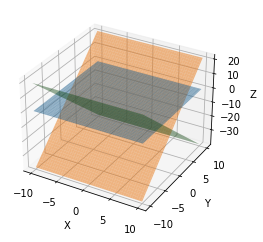

In [27]:
#visualize the planes that we fitted
#planes_fig = list(plane_coef.values())
planes_fig = refined_planes

# 创建数据点
x = np.linspace(-10, 10, 100) #绘图范围
y = np.linspace(-10, 10, 100)
x, y = np.meshgrid(x, y)

# 创建3D图形
fig = plt.figure()
plt3d = fig.add_subplot(111, projection='3d')

# 绘制多个平面
for plane in planes_fig:
    A, B, C, D = plane
    z = (-A * x - B * y - D) / C
    plt3d.plot_surface(x, y, z, alpha=0.5)

# 设置坐标轴标签
plt3d.set_xlabel('X')
plt3d.set_ylabel('Y')
plt3d.set_zlabel('Z')

# 显示图形
plt.show()

- Each surface, we got a group of file to save the data. (每个面用一组数据进行单独储存)

In [28]:
from data_processing.save_by_dif_csv import save_clusters_to_csv

In [29]:
f = pd.read_csv(f"./data/rotated_data/{file_name}_rot_clu.csv")
f['cluster'] = f['cluster'].astype(int)
f.to_csv(f"./data/rotated_data/{file_name}_rot_clu.csv")

In [30]:
import os
# 假设 rotated_points 是你需要保存的numpy数组
# rotated_points = np.array(...) 

output_path = f"./data/rotated_data/{file_name}"

# 确保目标路径存在
os.makedirs(output_path, exist_ok=True)

In [31]:
save_clusters_to_csv(f"./data/rotated_data/{file_name}_rot_clu.csv",f"{file_name}/","jie5")

Saved to: plane_0.csv
Saved to: plane_1.csv
Saved to: plane_2.csv


In [32]:
from format_transformation.csv2txt import csv_to_txt

In [33]:
n_planes = 3
#csv ----> txt
for i in range (0, n_planes):
    input = f'./data/rotated_data/{file_name}/{file_name}_plane_{i}/plane_{i}.csv'
    output = f'./data/rotated_data/{file_name}/{file_name}_plane_{i}/plane_{i}.txt'

    csv_to_txt(input,output)   

In [37]:
# txt ----> pcd
for i in range (0, n_planes):
    input = f'./data/rotated_data/{file_name}/{file_name}_plane_{i}/plane_{i}.txt'
    output = f'./data/rotated_data/{file_name}/{file_name}_plane_{i}/plane_{i}_acs.pcd'

    txt_to_pcd(input,output)   

- python.open3d处理binary编码的点云文件,故因此需要格式转化

In [38]:
#ascii ----> binary
for i in range (0, n_planes):
    input = f'./data/rotated_data/{file_name}/{file_name}_plane_{i}/plane_{i}_acs.pcd'
    output = f'./data/rotated_data/{file_name}/{file_name}_plane_{i}/plane_{i}_bin.pcd'

    ascii_to_binary(input,output)   

### 2.3 : Extract Key Point 

- In this section, we find the key point (centroid point) individually from each plane
- This procedure contains 8 steps:
    - Get the .pcd file (which we already generated in 2.2)
    - Use "slicing_pt_multi_v2" get the first direction sliced
    - Use "slicing_pt_multi_2_v2"
    - dealing with the split data
    - ~~final_info_process to combine the above steps~~
    - ~~generate final parts~~
    - Calculate the regional-centroid point
    - Move back to the original position (base on the direction and slice_distance) ----> this step saves millions of times lol

- 2.3.1 Slicing in first direction

In [16]:
from data_processing.extract_key_point.slicing_pt_multi_v2 import slice_and_save_point_clouds

In [18]:
import open3d as o3d
import os
import numpy as np

In [59]:
#处理哪个面 (从面0开始计数！)
flag = 2
file_name = "jie5"

In [25]:
#define the slicing params (direction, distance)
direction = np.array([1, 0, 0]) #沿X轴切
slice_distance = 0.2 #切分距离
gap_distance = 1

In [26]:
#define some params
pcd = o3d.io.read_point_cloud(f"./data/rotated_data/{file_name}/{file_name}_plane_{flag}/plane_{flag}_bin.pcd")

output_path_pcd = f"./data/slicing_data/{file_name}/{file_name}_plane_{flag}/data_slicing_1"
output_path_csv = f"./data/slicing_data/{file_name}/{file_name}_plane_{flag}/data_csv"
#output_file = f"plane{flag}_split"
#full_path = os.path.join(output_path, output_file) #创建相应文件夹和.txt文件

# 确保目标路径存在
os.makedirs(output_path_pcd, exist_ok=True)
os.makedirs(output_path_csv, exist_ok=True)

In [27]:
slice_and_save_point_clouds(pcd, direction, slice_distance, gap_distance, output_path_pcd, output_path_csv, flag)

Saved slice to ./data/slicing_data/jie5/jie5_plane_0/data_slicing_1/slice_0.pcd
Saved slice to ./data/slicing_data/jie5/jie5_plane_0/data_slicing_1/slice_1.pcd
Saved slice to ./data/slicing_data/jie5/jie5_plane_0/data_slicing_1/slice_2.pcd
Saved slice to ./data/slicing_data/jie5/jie5_plane_0/data_slicing_1/slice_3.pcd
Saved slice to ./data/slicing_data/jie5/jie5_plane_0/data_slicing_1/slice_4.pcd
Saved slice to ./data/slicing_data/jie5/jie5_plane_0/data_slicing_1/slice_5.pcd
Saved slice to ./data/slicing_data/jie5/jie5_plane_0/data_slicing_1/slice_6.pcd
Saved slice to ./data/slicing_data/jie5/jie5_plane_0/data_slicing_1/slice_7.pcd
Saved slice to ./data/slicing_data/jie5/jie5_plane_0/data_slicing_1/slice_8.pcd
Saved slice to ./data/slicing_data/jie5/jie5_plane_0/data_slicing_1/slice_9.pcd
Saved slice to ./data/slicing_data/jie5/jie5_plane_0/data_slicing_1/slice_10.pcd
Saved slice to ./data/slicing_data/jie5/jie5_plane_0/data_slicing_1/slice_11.pcd
Saved slice to ./data/slicing_data/jie

- Until now, we got the slicing data in first direction

- 2.3.2 Slicing in second direction

In [28]:
#from data_processing.extract_key_point.slicing_pt_multi_2_v2 import process_folder
from data_processing.extract_key_point.slicing_pt_multi_2_v3 import process_folder

In [29]:
import numpy as np
#direction = np.array([0, 0, 1])
direction = np.array([0,1,0]) #水平面专用
slice_distance = 0.2
gap_distance = 1

In [30]:
#define path 2
import os
input_folder = f"./data/slicing_data/{file_name}/{file_name}_plane_{flag}/data_slicing_1"

output_path = f"./data/slicing_data/{file_name}/{file_name}_plane_{flag}/data_slicing_2"
info_path = f"./data/slicing_data/{file_name}/{file_name}_plane_{flag}/data_slicing_2/info"
#output_file = f"plane{flag}_split"
#full_path = os.path.join(output_path, output_file) #创建相应文件夹和.txt文件

# 确保目标路径存在
os.makedirs(output_path, exist_ok=True)
os.makedirs(info_path, exist_ok=True)

In [31]:
process_folder(input_folder, direction, slice_distance, gap_distance, output_path)
#slice_and_save_point_clouds(pcd, direction, slice_distance, gap_distance, output_path_pcd, output_path_csv, flag)

Saved slice_0_slice_with_gap_000.pcd
Saved slice data to ./data/slicing_data/jie5/jie5_plane_0/data_slicing_2\info\slice_0_slice_with_gap_000.csv
Saved slice_0_slice_with_gap_001.pcd
Saved slice data to ./data/slicing_data/jie5/jie5_plane_0/data_slicing_2\info\slice_0_slice_with_gap_001.csv
Saved slice_0_slice_with_gap_002.pcd
Saved slice data to ./data/slicing_data/jie5/jie5_plane_0/data_slicing_2\info\slice_0_slice_with_gap_002.csv
Saved slice_0_slice_with_gap_003.pcd
Saved slice data to ./data/slicing_data/jie5/jie5_plane_0/data_slicing_2\info\slice_0_slice_with_gap_003.csv
Saved slice_0_slice_with_gap_004.pcd
Saved slice data to ./data/slicing_data/jie5/jie5_plane_0/data_slicing_2\info\slice_0_slice_with_gap_004.csv
Saved slice_0_slice_with_gap_005.pcd
Saved slice data to ./data/slicing_data/jie5/jie5_plane_0/data_slicing_2\info\slice_0_slice_with_gap_005.csv
Saved slice_0_slice_with_gap_006.pcd
Saved slice data to ./data/slicing_data/jie5/jie5_plane_0/data_slicing_2\info\slice_0_s

In [22]:
#可选操作
import os

def delete_files_starting_with(prefix, directory):
    # 遍历目录中的所有文件
    for filename in os.listdir(directory):
        if filename.startswith(prefix):
            file_path = os.path.join(directory, filename)
            os.remove(file_path)  # 删除文件
            print(f"Deleted {file_path}")

In [46]:
directory_path = f"./data/slicing_data/{file_name}/{file_name}_plane_{flag}/data_slicing_2"
delete_files_starting_with('slice_65', directory_path)
# delete_files_starting_with('slice_9', directory_path)
# delete_files_starting_with('slice_39', directory_path)

Deleted ./data/slicing_data/jie5/jie5_plane_0/data_slicing_2\slice_39_slice_with_gap_000.pcd
Deleted ./data/slicing_data/jie5/jie5_plane_0/data_slicing_2\slice_39_slice_with_gap_001.pcd
Deleted ./data/slicing_data/jie5/jie5_plane_0/data_slicing_2\slice_39_slice_with_gap_002.pcd
Deleted ./data/slicing_data/jie5/jie5_plane_0/data_slicing_2\slice_39_slice_with_gap_003.pcd
Deleted ./data/slicing_data/jie5/jie5_plane_0/data_slicing_2\slice_39_slice_with_gap_004.pcd
Deleted ./data/slicing_data/jie5/jie5_plane_0/data_slicing_2\slice_39_slice_with_gap_005.pcd
Deleted ./data/slicing_data/jie5/jie5_plane_0/data_slicing_2\slice_39_slice_with_gap_006.pcd
Deleted ./data/slicing_data/jie5/jie5_plane_0/data_slicing_2\slice_39_slice_with_gap_007.pcd
Deleted ./data/slicing_data/jie5/jie5_plane_0/data_slicing_2\slice_39_slice_with_gap_008.pcd
Deleted ./data/slicing_data/jie5/jie5_plane_0/data_slicing_2\slice_39_slice_with_gap_009.pcd
Deleted ./data/slicing_data/jie5/jie5_plane_0/data_slicing_2\slice_39_

- Now, we finished splitting the Point Cloud data!

- 2.3.3 Deal with the split data
    - 去掉 0 行（无效行）
    - 匹配对应行数据到原模型中 （因为在求质心时，我们使用原模型坐标进行求解）

In [66]:
# from data_processing.extract_key_point.deal_split_data import process_csv_files

In [67]:
# input_folder = f'./data/slicing_data/{file_name}/{file_name}_plane_{flag}/data_slicing_2/info/'

In [68]:
# process_csv_files(input_folder)

Processed and saved ./data/slicing_data/jie5/jie5_plane_2/data_slicing_2/info/slice_0_slice_with_gap_000.csv
Processed and saved ./data/slicing_data/jie5/jie5_plane_2/data_slicing_2/info/slice_0_slice_with_gap_003.csv
Processed and saved ./data/slicing_data/jie5/jie5_plane_2/data_slicing_2/info/slice_0_slice_with_gap_004.csv
Processed and saved ./data/slicing_data/jie5/jie5_plane_2/data_slicing_2/info/slice_0_slice_with_gap_005.csv
Processed and saved ./data/slicing_data/jie5/jie5_plane_2/data_slicing_2/info/slice_0_slice_with_gap_006.csv
Processed and saved ./data/slicing_data/jie5/jie5_plane_2/data_slicing_2/info/slice_0_slice_with_gap_007.csv
Processed and saved ./data/slicing_data/jie5/jie5_plane_2/data_slicing_2/info/slice_0_slice_with_gap_008.csv
Processed and saved ./data/slicing_data/jie5/jie5_plane_2/data_slicing_2/info/slice_0_slice_with_gap_009.csv
Processed and saved ./data/slicing_data/jie5/jie5_plane_2/data_slicing_2/info/slice_0_slice_with_gap_010.csv
Processed and saved

In [69]:
# import pandas as pd

In [71]:
# #得到plane_sli_info_1.csv文件 (第一次切分区域匹配)
# slice1_data = pd.read_csv(f"./data/slicing_data/{file_name}/{file_name}_plane_{flag}/data_csv/points_slice_info_plane{flag}.csv")
# plane_sli_info = slice1_data.iloc[:,0:4]
# plane_sli_info.to_csv(f"./data/slicing_data/{file_name}/{file_name}_plane_{flag}/data_csv/plane_sli_info_1.csv",index=False)

In [72]:
# from data_processing.extract_key_point.deal_split_data import update_target_with_p_XY
# from data_processing.extract_key_point.deal_split_data import update_target_with_p_XZ

- 立面应用update_target_with_p_XZ， 水平面应用update_target_with_p_XY

In [73]:
# slice2_data = pd.read_csv(f"./data/slicing_data/{file_name}/{file_name}_plane_{flag}/data_csv/points_adjusted_positions_plane{flag}.csv")
# slice2_data.to_csv(f"./data/slicing_data/{file_name}/{file_name}_plane_{flag}/data_csv/plane_sli_info_2.csv",index=False)

In [74]:
# #得到plane_sli_info_2.csv文件
# folder_path = f'./data/slicing_data/{file_name}/{file_name}_plane_{flag}/data_slicing_2/info'  # 替换为实际的文件夹路径
# target_csv_path = f'./data/slicing_data/{file_name}/{file_name}_plane_{flag}/data_csv/plane_sli_info_2.csv'  # 替换为实际的目标CSV文件路径

In [12]:
#水平面
#update_target_with_p_XY(folder_path, target_csv_path)

#立面
#update_target_with_p_XZ(folder_path, target_csv_path)

In [47]:
from data_processing.extract_key_point.centroid_point import compute_and_save_centroids

In [60]:
input_path = f'./data/slicing_data/{file_name}/{file_name}_plane_{flag}/data_slicing_2'
output_path = f'./data/slicing_data/{file_name}/{file_name}_plane_{flag}/data_centroid'
compute_and_save_centroids(input_path, output_path)

Saved centroid to ./data/slicing_data/jie5/jie5_plane_2/data_centroid\slice_10_slice_with_gap_000_centroid.pcd
Saved centroid to ./data/slicing_data/jie5/jie5_plane_2/data_centroid\slice_10_slice_with_gap_001_centroid.pcd
Saved centroid to ./data/slicing_data/jie5/jie5_plane_2/data_centroid\slice_10_slice_with_gap_002_centroid.pcd
Saved centroid to ./data/slicing_data/jie5/jie5_plane_2/data_centroid\slice_10_slice_with_gap_003_centroid.pcd
Saved centroid to ./data/slicing_data/jie5/jie5_plane_2/data_centroid\slice_10_slice_with_gap_004_centroid.pcd
Saved centroid to ./data/slicing_data/jie5/jie5_plane_2/data_centroid\slice_10_slice_with_gap_005_centroid.pcd
Saved centroid to ./data/slicing_data/jie5/jie5_plane_2/data_centroid\slice_10_slice_with_gap_006_centroid.pcd
Saved centroid to ./data/slicing_data/jie5/jie5_plane_2/data_centroid\slice_10_slice_with_gap_007_centroid.pcd
Saved centroid to ./data/slicing_data/jie5/jie5_plane_2/data_centroid\slice_10_slice_with_gap_008_centroid.pcd
S

In [49]:
from data_processing.extract_key_point.move_centroids_pcd import translate_and_save_centroids

In [61]:
input_folder = f'./data/slicing_data/{file_name}/{file_name}_plane_{flag}/data_centroid'
output_folder = f'./data/slicing_data/{file_name}/{file_name}_plane_{flag}/data_centroid_adj'
vector_z = [0,0,-1]
vector_y = [0,-1,0]
vector_x = [-1,0,0]

In [62]:
translate_and_save_centroids(input_folder, output_folder, vector_z, vector_x) #竖直面
#translate_and_save_centroids(input_folder, output_folder, vector_y, vector_x) #水平面

Processed and saved ./data/slicing_data/jie5/jie5_plane_2/data_centroid_adj\slice_10_slice_with_gap_000_centroid_adjust.pcd
Processed and saved ./data/slicing_data/jie5/jie5_plane_2/data_centroid_adj\slice_10_slice_with_gap_001_centroid_adjust.pcd
Processed and saved ./data/slicing_data/jie5/jie5_plane_2/data_centroid_adj\slice_10_slice_with_gap_002_centroid_adjust.pcd
Processed and saved ./data/slicing_data/jie5/jie5_plane_2/data_centroid_adj\slice_10_slice_with_gap_003_centroid_adjust.pcd
Processed and saved ./data/slicing_data/jie5/jie5_plane_2/data_centroid_adj\slice_10_slice_with_gap_004_centroid_adjust.pcd
Processed and saved ./data/slicing_data/jie5/jie5_plane_2/data_centroid_adj\slice_10_slice_with_gap_005_centroid_adjust.pcd
Processed and saved ./data/slicing_data/jie5/jie5_plane_2/data_centroid_adj\slice_10_slice_with_gap_006_centroid_adjust.pcd
Processed and saved ./data/slicing_data/jie5/jie5_plane_2/data_centroid_adj\slice_10_slice_with_gap_007_centroid_adjust.pcd
Processe

In [52]:
#merge the pcd_data
from data_processing.extract_key_point.merge_pcd import merge_pcd_files

In [63]:
input_pcd_path =  f'./data/slicing_data/{file_name}/{file_name}_plane_{flag}/data_centroid_adj'
output_pcd_path = f'./data/slicing_data/{file_name}/{file_name}_plane_{flag}/{file_name}_plane{flag}_centroids.pcd'

merge_pcd_files(input_pcd_path, output_pcd_path)

Saved merged point cloud to ./data/slicing_data/jie5/jie5_plane_2/jie5_plane2_centroids.pcd


In [ ]:
from data_processing.move_files import move_specified_files

In [ ]:
move_files(f'./data/slicing_data/{file_name}/{file_name}_plane_{flag}'
           ,f'./data/centroid_data/{file_name}'
           ,['{file_name}_plane{flag}_centroids.pcd'])

##### 以下内容为旧版本垃圾~

- 2.3.4 Combine 2 slicing_data.csv
    - Combine plane_sli_info_1.csv & plane_sli_info_2.csv

In [48]:
# file_1 = pd.read_csv(f"./data/slicing_data/{file_name}/{file_name}_plane_{flag}/data_csv/plane_sli_info_1.csv")
# file_1.head()

,X,Y,Z,Slice_Index
0,-0.212528,-3.159503,0.288085,0.0
1,-0.211027,-3.246203,0.534179,0.0
2,-0.208232,-3.091612,0.082519,0.0
3,-0.207352,-3.168567,0.326171,0.0
4,-0.207045,-3.142616,0.269531,0.0


In [49]:
# file_2 = pd.read_csv(f"./data/slicing_data/{file_name}/{file_name}_plane_{flag}/data_csv/plane_sli_info_2.csv")
# file_2.head()

,Adjusted_X,Adjusted_Y,Adjusted_Z,Slice_Index
0,-0.212528,-3.159503,0.288085,0.0
1,-0.211027,-3.246203,0.534179,1.0
2,-0.208232,-3.091612,0.082519,0.0
3,-0.207352,-3.168567,0.326171,0.0
4,-0.207045,-3.142616,0.269531,0.0


In [50]:
# file_fin = pd.DataFrame()

In [51]:
# file_fin["X"] = file_1["X"]
# file_fin["Y"] = file_1["Y"]
# file_fin["Z"] = file_1["Z"]
# file_fin["Slice_Index_1"] = file_1["Slice_Index"]
# file_fin["Slice_Index_2"] = file_2["Slice_Index"]

file_fin.head()

,X,Y,Z,Slice_Index_1,Slice_Index_2
0,-0.212528,-3.159503,0.288085,0.0,0.0
1,-0.211027,-3.246203,0.534179,0.0,1.0
2,-0.208232,-3.091612,0.082519,0.0,0.0
3,-0.207352,-3.168567,0.326171,0.0,0.0
4,-0.207045,-3.142616,0.269531,0.0,0.0


In [52]:
# file_fin.to_csv(f"./data/slicing_data/{file_name}/{file_name}_plane_{flag}/data_csv/file_fin_plane{flag}.csv",index=False)

- 2.3.5 Generate Final pcd file of the targeted plane

In [53]:
# import os

In [54]:
# output_path = f"./data/slicing_data/{file_name}/{file_name}_plane_{flag}/fin_point"

# # 确保目标路径存在
# os.makedirs(output_path, exist_ok=True)

In [55]:
# from data_processing.extract_key_point.generate_final_parts import save_groups_to_pcd

In [56]:
# csv_file_path = f"./data/slicing_data/{file_name}/{file_name}_plane_{flag}/data_csv/file_fin_plane{flag}.csv"
# output_path = f"./data/slicing_data/{file_name}/{file_name}_plane_{flag}/fin_point"
# save_groups_to_pcd(csv_file_path, output_path)

Saved ./data/slicing_data/plane_2/fin_point/points_group_0.0_0.0.pcd with 21 points.
Saved ./data/slicing_data/plane_2/fin_point/points_group_0.0_1.0.pcd with 19 points.
Saved ./data/slicing_data/plane_2/fin_point/points_group_0.0_2.0.pcd with 22 points.
Saved ./data/slicing_data/plane_2/fin_point/points_group_0.0_3.0.pcd with 21 points.
Saved ./data/slicing_data/plane_2/fin_point/points_group_0.0_4.0.pcd with 22 points.
Saved ./data/slicing_data/plane_2/fin_point/points_group_0.0_5.0.pcd with 19 points.
Saved ./data/slicing_data/plane_2/fin_point/points_group_0.0_6.0.pcd with 20 points.
Saved ./data/slicing_data/plane_2/fin_point/points_group_0.0_7.0.pcd with 19 points.
Saved ./data/slicing_data/plane_2/fin_point/points_group_0.0_8.0.pcd with 19 points.
Saved ./data/slicing_data/plane_2/fin_point/points_group_1.0_0.0.pcd with 18 points.
Saved ./data/slicing_data/plane_2/fin_point/points_group_1.0_1.0.pcd with 27 points.
Saved ./data/slicing_data/plane_2/fin_point/points_group_1.0_2.0.

- 2.3.6 Calculate the Centroid Point

In [57]:
# from data_processing.extract_key_point.centroid_point import calculate_centroids_and_save

In [58]:
# input_folder = f"./data/slicing_data/{file_name}/{file_name}_plane_{flag}/fin_point"
# output_path = "./data/centroid_data"
# output_file = output_path + f"/{file_name}/plane{flag}_centroids.pcd"

# os.makedirs(output_path, exist_ok=True)

In [59]:
# calculate_centroids_and_save(input_folder, output_file)

Saved centroid point cloud to ./data/centroid_data/plane2_centroids.pcd


- By then, we got the centroid point of the target plane!

- By doing this for n times, we can get the centroid points for each plane

### 2.4 : Supplementary operation

- We also need to do some extra works for acquiring a better model

- 2.4.1 calculate the intersection line of each 2 planes & generate virtual point cloud for connecting planes

In [50]:
from data_processing.surface_intersection_line import find_intersection_point, cross_product

In [51]:
refined_planes

[array([-0.00261544,  0.00517488,  0.99998319, -0.2656918 ]),
 array([-1.19459988e-03, -9.50512415e-01,  3.10684279e-01,  2.73193121e+00]),
 array([ 3.61508519e-04, -9.46719760e-01, -3.22058326e-01, -3.25341043e+00])]

In [52]:
#哪两个面进行求交线操作
a = 0
b = 2

In [53]:
direction = cross_product(np.array(refined_planes[a][:3]), np.array(refined_planes[b][:3]))
point_on_line = find_intersection_point(refined_planes[a], refined_planes[b], direction)
print(f"平面{a}和平面{b}的交线方向向量：",direction)
print(f"平面{a}和平面{b}的交线上的一点：",point_on_line)

平面0和平面2的交线方向向量： [ 9.45037231e-01 -4.80822726e-04  2.47422073e-03]
平面0和平面2的交线上的一点： [ 0.         -3.53311371  0.28398003]


In [54]:
from data_processing.calculate_pt_on_line import calculate_point_on_line

In [55]:
x=-(64.860901) #自行替换相应数据
calculate_point_on_line(x, point_on_line, direction) 

(-64.860901, -3.50011332168537, 0.11416641545501341)

In [56]:
start_point = np.array(calculate_point_on_line(x, point_on_line, direction))
direction = np.array(direction)

# 归一化方向向量
direction_normalized = direction / np.linalg.norm(direction)
# 设定p_max的值
p_max = 13  # 假设值，根据需要调整
# 每隔0.5的距离
distance = 0.2

In [57]:
start_point

array([-64.860901  ,  -3.50011332,   0.11416642])

In [58]:
from data_processing.calculate_pt_on_line import generate_points_and_save_as_pcd

In [41]:
# from tqdm import tqdm

In [45]:
# # 计算预期的迭代次数
# max_distance = start_point[0] + p_max
# estimated_steps = int(max_distance / distance)

In [48]:
# # 计算点的序列并加入tqdm进度条
# points = []
# current_point = start_point
# # 使用tqdm包装range对象，提供预计的迭代次数
# for _ in tqdm(range(estimated_steps), desc="Generating points"):
#     if current_point[0] <= max_distance:
#         points.append(current_point)
#         current_point = current_point + direction_normalized * distance
#     else:
#         break  # 如果当前点超过了最大值，则停止循环

Generating points:  17%|█▋        | 86/510 [00:00<?, ?it/s]


In [59]:
# import os
# points_array = np.array(points)
# #print(points)

# # 创建点云对象
# point_cloud = o3d.geometry.PointCloud()

# # 将NumPy数组中的点添加到点云中
# point_cloud.points = o3d.utility.Vector3dVector(points_array)
import os
output_path = f"./data/extra_data/{file_name}"
os.makedirs(output_path, exist_ok=True)
# 保存点云到PCD文件
#o3d.io.write_point_cloud(output_path + f"/extra_{file_name}_plane{a}_plane{b}.pcd", point_cloud, write_ascii=False)
output_file = output_path + f"/extra_{file_name}_plane{a}_plane{b}.pcd"

In [60]:
#generate底面点
generate_points_and_save_as_pcd(start_point, direction, distance, p_max, output_file)

Saved 66 points to ./data/extra_data/jie5/extra_jie5_plane0_plane2.pcd


- 底面点生成完毕后，为使得模型与结构形式相似，应当对顶部点也进行统一化处理

In [61]:
#generate顶点
start_point = np.array([-64.813934,-4.978764,4.467955]) #需要自行通过cloudcompare查找相应的点!
output_file_2 = output_path + f"/extra_{file_name}_plane{a}_plane{b}_ding.pcd"

In [62]:
generate_points_and_save_as_pcd(start_point, direction, distance, p_max, output_file_2)

Saved 66 points to ./data/extra_data/jie5/extra_jie5_plane0_plane2_ding.pcd


In [67]:
visualize_pcds([f'data/extra_data/{file_name}/extra_{file_name}_plane{a}_plane{b}.pcd'
               ,f'data/extra_data/{file_name}/extra_{file_name}_plane{a}_plane{b}_ding.pcd'
               #,f'./data/slicing_data/{file_name}/{file_name}_plane_{a}/{file_name}_plane{a}_centroids_modified.pcd'
               #,f'./data/slicing_data/{file_name}/{file_name}_plane_{b}/{file_name}_plane{b}_centroids_modified.pcd'
               ,f'./data/centroid_data/jie5/{file_name}_plane{b}_centroids_modified.pcd'
                ]
                )

- 如果与实际情况不相符，请尝试调转面a,b的赋值
- 若想求指定x数值的在交线上的起始点，请尝试调用find_point_on_line函数
- 若要求多组平面的相交线，请更改a,b值进行并重新运行本模块的代码

- 2.4.2 合并上述点云数据

In [68]:
from data_processing.extract_key_point.merge_pcd import merge_pcd_files

In [53]:
#merged centroid points
pcd_file_dir = f"./data/centroid_data/{file_name}"
output_pcd_file = f'./data/centroid_data/{file_name}/{file_name}_merged_centroid.pcd'

merge_pcd_files(pcd_file_dir, output_pcd_file)

Saved merged point cloud to ./data/centroid_data/jie5/jie5_merged_centroid.pcd


In [50]:
#merged extra generated data (lines)
pcd_file_dir = f"./data/extra_data/{file_name}"
output_pcd_file = f'./data/extra_data/{file_name}/{file_name}_merged_extra.pcd'

merge_pcd_files(pcd_file_dir, output_pcd_file)

Saved merged point cloud to ./data/extra_data/jie5/jie5_merged_extra.pcd


In [51]:
merged_pcd = o3d.geometry.PointCloud()

pcd_1 = o3d.io.read_point_cloud(f"./data/centroid_data/{file_name}/{file_name}_merged_centroid.pcd")
pcd_2 = o3d.io.read_point_cloud(f"./data/extra_data/{file_name}/{file_name}_merged_extra.pcd")

output_path = f"./data/final_data/{file_name}"
file_name_t = f"/{file_name}_final_point_cloud.pcd"
output_file = output_path + file_name_t

os.makedirs(output_path, exist_ok=True)

In [52]:
merged_pcd = pcd_1 + pcd_2

o3d.io.write_point_cloud(output_file, merged_pcd)
print(f"Saved merged point cloud to {output_file}")

Saved merged point cloud to ./data/final_data/jie5/jie5_final_point_cloud.pcd


In [69]:
a = 2
b = 0
c = 1

In [70]:
file_name='jie5'

In [71]:
#分平面的点云数据
merged_pcd = o3d.geometry.PointCloud()

pcd_1 = o3d.io.read_point_cloud(f"./data/centroid_data/{file_name}/{file_name}_plane{a}_centroids_modified.pcd")
pcd_2 = o3d.io.read_point_cloud(f"./data/extra_data/{file_name}/extra_{file_name}_plane{b}_plane{a}.pcd")
pcd_3 = o3d.io.read_point_cloud(f"./data/extra_data/{file_name}/extra_{file_name}_plane{b}_plane{a}_ding.pcd")

merged_pcd = pcd_1 + pcd_2 + pcd_3

output_path = f"./data/final_data/{file_name}"
file_name_t = f"/{file_name}_final_point_cloud_p{a}.pcd"
output_file = output_path + file_name_t

o3d.io.write_point_cloud(output_file, merged_pcd)
print(f"Saved merged point cloud to {output_file}")

Saved merged point cloud to ./data/final_data/jie5/jie5_final_point_cloud_p2.pcd


In [63]:
#水平面
merged_pcd = o3d.geometry.PointCloud()

pcd_1 = o3d.io.read_point_cloud(f"./data/centroid_data/{file_name}/{file_name}_plane{b}_centroids.pcd")
pcd_2 = o3d.io.read_point_cloud(f"./data/extra_data/{file_name}/extra_{file_name}_plane{b}_plane{a}.pcd")
pcd_3 = o3d.io.read_point_cloud(f"./data/extra_data/{file_name}/extra_{file_name}_plane{b}_plane{c}.pcd")

merged_pcd = pcd_1 + pcd_2 + pcd_3

output_path = f"./data/final_data/{file_name}"
file_name_t = f"/{file_name}_final_point_cloud_p{b}.pcd"
output_file = output_path + file_name_t

o3d.io.write_point_cloud(output_file, merged_pcd)
print(f"Saved merged point cloud to {output_file}")

Saved merged point cloud to ./data/final_data/jie5/jie5_final_point_cloud_p0.pcd


In [64]:
merged_pcd = o3d.geometry.PointCloud()

pcd_1 = o3d.io.read_point_cloud(f"./data/centroid_data/{file_name}/{file_name}_plane{c}_centroids.pcd")
pcd_2 = o3d.io.read_point_cloud(f"./data/extra_data/{file_name}/extra_{file_name}_plane{b}_plane{c}.pcd")

merged_pcd = pcd_1 + pcd_2

output_path = f"./data/final_data/{file_name}"
file_name_t = f"/{file_name}_final_point_cloud_p{c}.pcd"
output_file = output_path + file_name_t

o3d.io.write_point_cloud(output_file, merged_pcd)
print(f"Saved merged point cloud to {output_file}")

Saved merged point cloud to ./data/final_data/jie5/jie5_final_point_cloud_p1.pcd


- 2.4.3 Format Transformation

In [72]:
flag = 2 #处理哪个面

In [73]:
from format_transformation.binary_to_ascii import binary_to_ascii

In [74]:
#.pcd ----> .csv
filename = f"./data/final_data/{file_name}/{file_name}_final_point_cloud_p{flag}.pcd"
output_filename = f"./data/final_data/{file_name}/{file_name}_final_point_cloud_p{flag}_ascii.pcd"

binary_to_ascii(filename, output_filename)

Hello, world!
PointCloud_source has: 1518 data points.


In [75]:
from format_transformation.pcd2txt import pcd_to_txt

In [76]:
pcd_file = f"./data/final_data/{file_name}/{file_name}_final_point_cloud_p{flag}_ascii.pcd"
txt_file = f"./data/final_data/{file_name}/{file_name}_final_point_cloud_p{flag}_txt.txt"
pcd_to_txt(pcd_file, txt_file)

In [77]:
from format_transformation.txt_2_csv import txt_to_csv_with_columns

In [78]:
txt_file = f"./data/final_data/{file_name}/{file_name}_final_point_cloud_p{flag}_txt.txt"
csv_file = f"./data/final_data/{file_name}/{file_name}_final_point_cloud_p{flag}_csv.csv"

txt_to_csv_with_columns(txt_file, csv_file)

- For now, we finished the data processing part!

## PART 3 : 3D Reconstruction 

In [79]:
import os

In [80]:
file_name="jie5"

In [81]:
td_path = f"./data/TDR_data/{file_name}"
os.makedirs(td_path, exist_ok=True)

In [82]:
from TD_Reconstruction.bpa_plane import bpa_rec

In [83]:
from TD_Reconstruction.add_id import add_id

In [84]:
flag = 2

In [85]:
csv_file = f"./data/final_data/{file_name}/{file_name}_final_point_cloud_p{flag}_csv.csv"
updated_csv_file_path = f"./data/final_data/{file_name}/{file_name}_final_point_cloud_p{flag}_csv_id.csv" #用不用改成TD 文件夹？

add_id(csv_file, flag, updated_csv_file_path)

- id命名规则：面编号（从1开始）+ 点编号

In [86]:
csv_file = f"./data/final_data/{file_name}/{file_name}_final_point_cloud_p{flag}_csv_id.csv"
output_csv = f"./data/TDR_data/{file_name}/{file_name}_plane{flag}_REC.csv"
radii = [0.05, 0.2, 0.5, 2]

bpa_rec(csv_file, output_csv, radii)

2861


## PART 4 : Convert into ANSYS APDL

In [87]:
flag = 2

In [88]:
from TD_Reconstruction.csv2ansys import Generate_KP, Generate_AREA

In [89]:
output_path = f"./data/TDR_data/ball_pivoting/{file_name}"
os.makedirs(output_path, exist_ok=True)

- 4.1 Generate Keypoints

In [90]:
csv_file = f"./data/final_data/{file_name}/{file_name}_final_point_cloud_p{flag}_csv_id.csv"
output_txt = f"./data/TDR_data/ball_pivoting/{file_name}/{file_name}_plane{flag}_KP.txt"

Generate_KP(csv_file, output_txt)

- 4.2 Generate AREA

In [91]:
csv_file = f"./data/TDR_data/{file_name}/{file_name}_plane{flag}_REC.csv"
output_txt = f"./data/TDR_data/ball_pivoting/{file_name}/{file_name}_plane{flag}_AREA.txt"

Generate_AREA(csv_file, output_txt)

- Now you may get 2*number of planes' ANSYS APDL File. That's what we need to build up the model in ANSYS. Just copy those file into your ANSYS APDL .txt file, and then add the material definition part and restraint part and load part .......